<a href="https://colab.research.google.com/github/Raylow00/reverse-vending-machine/blob/main/(1291_images_per_class)_Binary_Classification_of_Plastic_Bottles_and_Aluminium_Cans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This dataset contains two classes: Plastic bottles and Aluminium cans.

Plastic bottles:
  - train: 903 images
  - validation: 193 images
  - test: 195 images

Aluminium cans:
  - train: 903 images
  - validation: 193 images
  - test: 195 images

All images are resized to (224, 224, 3) prior to feeding into network. The resized images are not heavily distorted but this step was to check whether the features are suppressed after resizing.

In [45]:
!unzip /content/drive/My\ Drive/Reverse\ Vending\ Machine/ObjectDetector/v2/my_dataset_split_v2.zip > /dev/null

replace 1293_split_v2/test/bottle/0217015045.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [47]:
train_data = '1293_split_v2/train'
val_data = '1293_split_v2/val'
test_data = '1293_split_v2/test'

The generate_data() function helps to retrieve images from the directory and perform any necessary preprocessing steps such as augmentation.

In [48]:
def generate_data(train_dir, val_dir, test_dir, image_size=224, class_mode="binary", augmentation=False):
  if augmentation:
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=15,
                                   vertical_flip=True,
                                   fill_mode='reflect',
                                   data_format='channels_last',
                                   brightness_range=[0.5, 1.5],
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)
  else:
    train_datagen = ImageDataGenerator(rescale=1./255)

  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=5, class_mode=class_mode)
  validation_generator = test_datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=2, class_mode=class_mode)
  test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=2, class_mode=class_mode, shuffle=False)

  # Output of the generator
  for data, label in train_generator:
    print("Data batch shape: ", data.shape)
    print("Label batch shape: ", label.shape)
    break

  return train_generator, validation_generator, test_generator

We are using transfer learning here with a base network of VGG16 paired with the weights of ImageNet. Transfer learning is preferred when there is not a lot of data to start with, and it can also save some training time.

In [49]:
from tensorflow.keras.layers import Input
vgg16 = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
model = Sequential()
for layer in vgg16.layers[:-1]:
  model.add(layer)

for layer in model.layers:
  layer.trainable = False

model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [50]:
# Train
model.compile(optimizer=Adam(learning_rate=1e-5), 
                loss='binary_crossentropy', 
                metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()])

In [51]:
train_generator, validation_generator, test_generator = generate_data(train_data, val_data, test_data, class_mode="binary", augmentation=False)

Found 1806 images belonging to 2 classes.
Found 386 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Data batch shape:  (5, 224, 224, 3)
Label batch shape:  (5,)


In [52]:
tf.config.run_functions_eagerly(True)
history = model.fit_generator(train_generator, 
                                steps_per_epoch=10, 
                                epochs=50, 
                                validation_data=validation_generator, 
                                validation_steps=10
                                )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


10/10 [==============================] - 2s 192ms/step - loss: 0.7419 - accuracy: 0.5600 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - auc_1: 0.1833 - val_loss: 0.7308 - val_accuracy: 0.5500 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_auc_1: 0.2576
Epoch 2/50
10/10 [==============================] - 2s 212ms/step - loss: 0.7697 - accuracy: 0.4200 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - auc_1: 0.3415 - val_loss: 0.7151 - val_accuracy: 0.5500 - val_recall_1: 0.1000 - val_precision_1: 1.0000 - val_auc_1: 0.4800
Epoch 3/50
10/10 [==============================] - 2s 211ms/step - loss: 0.7061 - accuracy: 0.5200 - recall_1: 0.1852 - precision_1: 0.7143 - auc_1: 0.4976 - val_loss: 0.6639 - val_accuracy: 0.6000 - val_recall_1: 0.3333 - val_precision_1: 0.6000 - val_auc_1: 0.7020
Epoch 4/50
10/10 [==============================] - 2s 212ms/step - loss: 0.6867 - accuracy: 0.5400 - recall_1: 0.5000 - precision_1: 0.6087 - auc_1: 0.5552 - val_loss: 0.6721 - val_a

(0.0, 2.0)

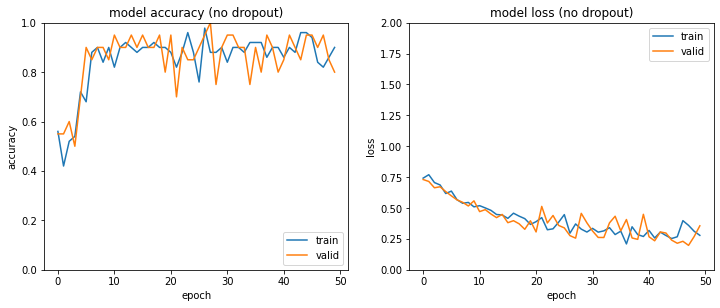

In [53]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy (no dropout)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (no dropout)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.ylim([0,2])


From the accuracy graph above, the model can be said to be training quite well, though the validation accuracy fluctuates a lot more than the training accuracy, which might indicate several things:
1. The images in the dataset are not exactly equal in terms of lighting conditions. This might be one of the reasons the accuracy fluctuated as it could not learn the pattern.
2. The size of (224, 224) might have caused some distortions in certain images.

However, in general, it is still able to reach an accuracy of over 90%.

From the loss graph above, both the training and validation loss seem to decrease steadily and the validation loss follows closely with the training loss, hence there seems to be no overfitting. While there is a little fluctuation in the graph, the reasons could be the same.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


{'bottle': 0, 'can': 1}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[0.1357119 ]
 [0.11251707]
 [0.14431567]
 [0.1548854 ]
 [0.117785  ]
 [0.10373734]
 [0.13443288]
 [0.11364374]
 [0.1378668 ]
 [0.09750162]
 [0.13754189]
 [0.13487118]
 [0.13093448]
 [

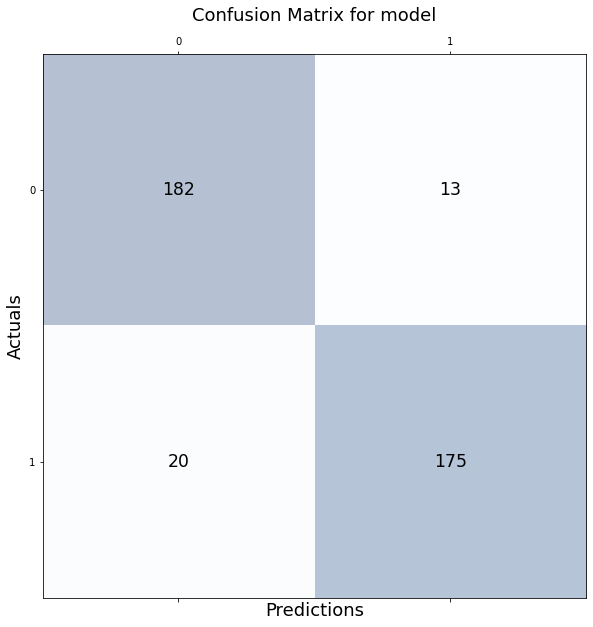

In [54]:
test_metrics = model.evaluate_generator(test_generator, steps=2)
predictions = model.predict_generator(test_generator)
print(test_generator.class_indices)
print(test_generator.classes)
print(predictions)
pred = [int(i > 0.5) for i in predictions]
# pred = [np.argmax(i) for i in predictions]
print(pred)

# Confusion matrix
y_true = test_generator.classes
y_pred = pred

# Classification report
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for model', fontsize=18)
plt.show()

Predictions on the test sest reveals that the model is generally learning the pattern of the dataset well, but the overall accuracy could be improved.

The next step in this notebook will be to attempt to convert false positives and false negatives to true positives and true negatives. The wrongly predicted images have to be analyzed to find out the reason why the model is doing so. Then, when the metrics are improved, a real-world set of images under different lighting conditions will be taken and the model will make corresponding predictions.

In [55]:
# Save the model
model.save("/content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/saved_model/my_model")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/saved_model/my_model/assets


##Inference

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [57]:
# Convert the model to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/saved_model/my_model") # path to the SavedModel directory
tflite_model = converter.convert()

with open('/content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/saved_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [58]:
# Copyright 2018 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""label_image for tflite."""

import argparse
import time

import numpy as np
from PIL import Image
import tensorflow as tf


def load_labels(filename):
  with open(filename, 'r') as f:
    return [line.strip() for line in f.readlines()]


MODEL = '/content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/saved_model.tflite'
IMAGE = '/content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/can_1.jpg'
LABEL_FILE = '/content/drive/My Drive/Reverse Vending Machine/ObjectDetector/v2/labels.txt'
INPUT_MEAN = 127.5
INPUT_STD = 127.5
NUM_THREADS = None
EXT_DELEGATE_OPTIONS = None


ext_delegate = None
ext_delegate_options = {}

# parse extenal delegate options
if EXT_DELEGATE_OPTIONS is not None:
  options = EXT_DELEGATE_OPTIONS.split(';')
  for o in options:
    kv = o.split(':')
    if (len(kv) == 2):
      ext_delegate_options[kv[0].strip()] = kv[1].strip()
    else:
      raise RuntimeError('Error parsing delegate option: ' + o)

# load external delegate
if EXT_DELEGATE_OPTIONS is not None:
  print('Loading external delegate from {} with args: {}'.format(
      EXT_DELEGATE_OPTIONS, ext_delegate_options))
  ext_delegate = [
      tflite.load_delegate(EXT_DELEGATE_OPTIONS, ext_delegate_options)
  ]

interpreter = tf.lite.Interpreter(
    model_path=MODEL,
    experimental_delegates=ext_delegate,
    num_threads=NUM_THREADS)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# check the type of the input tensor
floating_model = input_details[0]['dtype'] == np.float32
print("Floating model: ", floating_model)

# NxHxWxC, H:1, W:2
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]
print("Height: {}, Width: {}".format(height, width))
img = Image.open(IMAGE).resize((width, height))

# add N dim
input_data = np.expand_dims(img, axis=0)

if floating_model:
  input_data = (np.float32(input_data) - INPUT_MEAN) / INPUT_STD

interpreter.set_tensor(input_details[0]['index'], input_data)

start_time = time.time()
interpreter.invoke()
stop_time = time.time()

output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)
print("Output data: ", output_data)
print("Results: ", results)

if results > 0.5:
  prediction = "can"
else:
  prediction = "bottle"

print("Prediction: ", prediction)

print('time: {:.3f}ms'.format((stop_time - start_time) * 1000))

Floating model:  True
Height: 224, Width: 224
Output data:  [[0.7657963]]
Results:  0.7657963
Prediction:  can
time: 429.653ms
